# Step 5b: Modeling

why LBM?


In [1]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

from src import preprocessing
from src import features
from src import config
from src import forecast

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
from importlib import reload

c:\Users\gorav\GitHub\nyc-311-service-requests\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Usage Instructions

This notebook uses the feature engineering module from `src/features.py`.

To run this notebook:
1. Ensure you have data in `data/landing/311-service-requests/`
2. Run `pip install -r requirements.txt` to install dependencies
3. Execute cells sequentially

For detailed documentation, see `src/FEATURE_ENGINEERING_README.md`


## Load Data

In [2]:
forecast_panel = pd.read_parquet(config.PRESENTATION_DATA_PATH + '/model_fitting_data.parquet')


## Fit Modesl

In [3]:
numerical_columns = config.NUMERICAL_COLUMNS

categorical_columns = config.CATEGORICAL_COLUMNS
horizons = [1]

### Fit Mean Models

In [4]:
bundle_mean = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    'mean'
)

Training model for horizon 1
X shape pre-filtering: (547535, 29)
X shape post-filtering: (547535, 29)
Train dates [2009-12-29 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (487161, 29)
X test shape: (60374, 29)
CV (neg_mean_absolute_error) scores: [-0.94076096 -0.60979388 -0.64066447 -0.64385908 -0.67775132 -0.71955493
 -0.76112183 -0.76665566 -0.7551152  -0.75035423 -0.71624205 -0.83113609
 -0.85166223 -0.83887812]
CV mean: -0.7502535751135685
train metrics
  h=1: RMSE=1.148, MAE=0.722, Poisson Dev=1.089
test metrics
  h=1: RMSE=1.434, MAE=0.820, Poisson Dev=1.247



### Fit 90th Percentile Models

In [5]:
bundle_90 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    '90'
)

Training model for horizon 1
X shape pre-filtering: (547535, 29)
X shape post-filtering: (547535, 29)
Train dates [2009-12-29 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (487161, 29)
X test shape: (60374, 29)
CV (neg_mean_absolute_error) scores: [-1.7811236  -1.14351159 -1.21058887 -1.24003852 -1.28611643 -1.33332779
 -1.41326011 -1.44626399 -1.4488491  -1.43531879 -1.37488268 -1.45606615
 -1.63384584 -1.65748101]
CV mean: -1.418619605391738
train metrics
  h=1: RMSE=1.890, MAE=1.439, Poisson Dev=2.148
test metrics
  h=1: RMSE=2.174, MAE=1.571, Poisson Dev=2.314



### Fit 50th Percentile Models

In [6]:
bundle_50 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    '50'
)

Training model for horizon 1
X shape pre-filtering: (547535, 29)
X shape post-filtering: (547535, 29)
Train dates [2009-12-29 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (487161, 29)
X test shape: (60374, 29)
CV (neg_mean_absolute_error) scores: [-0.67148251 -0.52536925 -0.55770819 -0.55727678 -0.60130335 -0.6480034
 -0.69641962 -0.69359785 -0.68247694 -0.67658521 -0.630352   -0.76266603
 -0.76547913 -0.74983095]
CV mean: -0.6584679427414095
train metrics
  h=1: RMSE=1.256, MAE=0.650, Poisson Dev=6.054
test metrics
  h=1: RMSE=1.496, MAE=0.735, Poisson Dev=6.193



### Fit 10th Percentile Models

In [7]:
bundle_10 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    '10'
)

Training model for horizon 1
X shape pre-filtering: (547535, 29)
X shape post-filtering: (547535, 29)
Train dates [2009-12-29 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (487161, 29)
X test shape: (60374, 29)
CV (neg_mean_absolute_error) scores: [-0.64399041 -0.6243259  -0.68516051 -0.67091056 -0.74989556 -0.8262046
 -0.89716131 -0.90139993 -0.87814252 -0.86437071 -0.77073199 -0.99554494
 -1.00433231 -0.97626396]
CV mean: -0.8206025123822276
train metrics
  h=1: RMSE=1.688, MAE=0.829, Poisson Dev=24.315
test metrics
  h=1: RMSE=2.035, MAE=0.932, Poisson Dev=25.099



### Save All Bundles

In [8]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# forecast.save_bundle(bundle_mean,  timestamp, 'lgb_mean.pkl')
# forecast.save_bundle(bundle_90,  timestamp, 'lgb_90.pkl')
# forecast.save_bundle(bundle_50,  timestamp, 'lgb_50.pkl')
# forecast.save_bundle(bundle_10,  timestamp, 'lgb_10.pkl')

## Evaluate Models

### Evaluate Mean Models

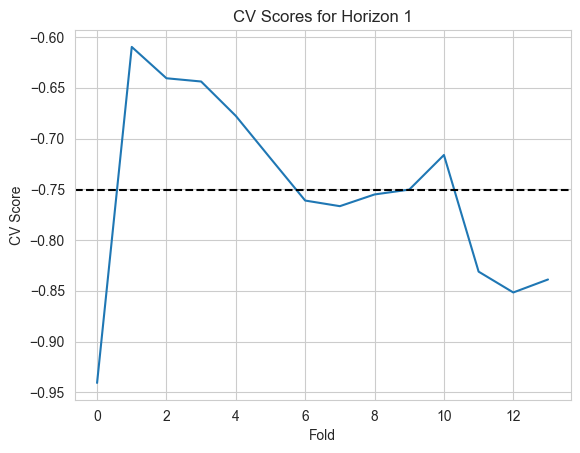

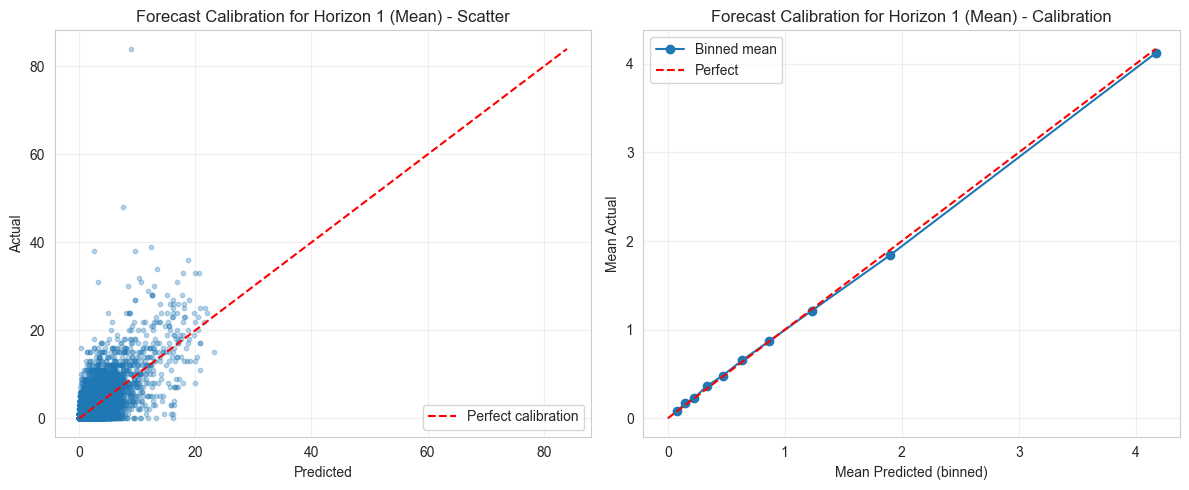

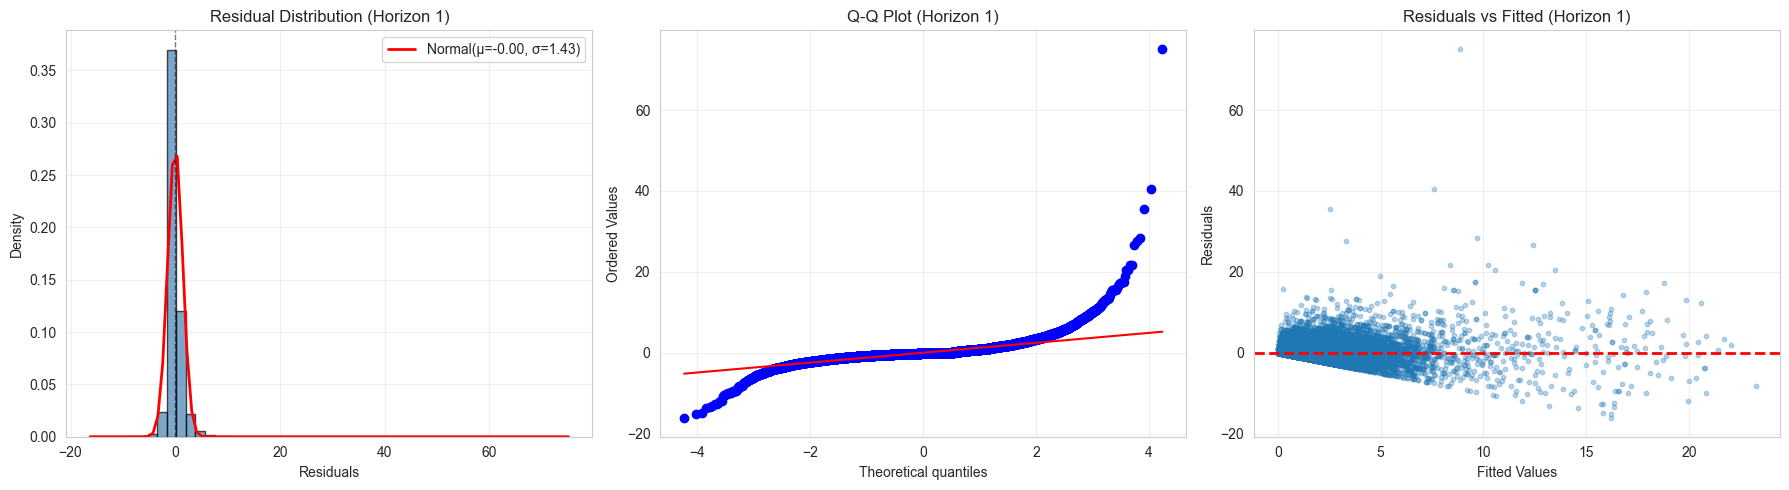


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: -0.0034
  Std Dev: 1.4337
  Median: -0.1806
  Skewness: 5.1749
  Kurtosis: 166.8895

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.8308
  P-value: 1.7885e-58
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 3537.6760
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.1482355904431094, 'mae': 0.7219054197009894, 'poisson_deviance': 1.0894649517431936, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 1.4336460329298772, 'mae': 0.8200716440522238, 'poisson_deviance': 1.247148720951562, 'n_samples': 60374}}



In [14]:
reload(forecast)
forecast.evaluate_models(bundle_mean, model_type = 'mean')

### Evaluate 90th Percentile Models

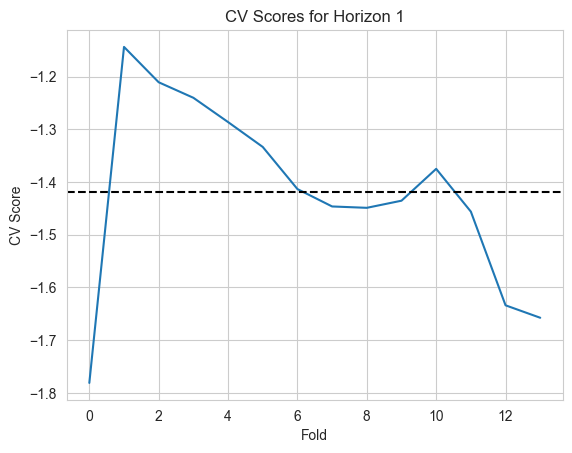

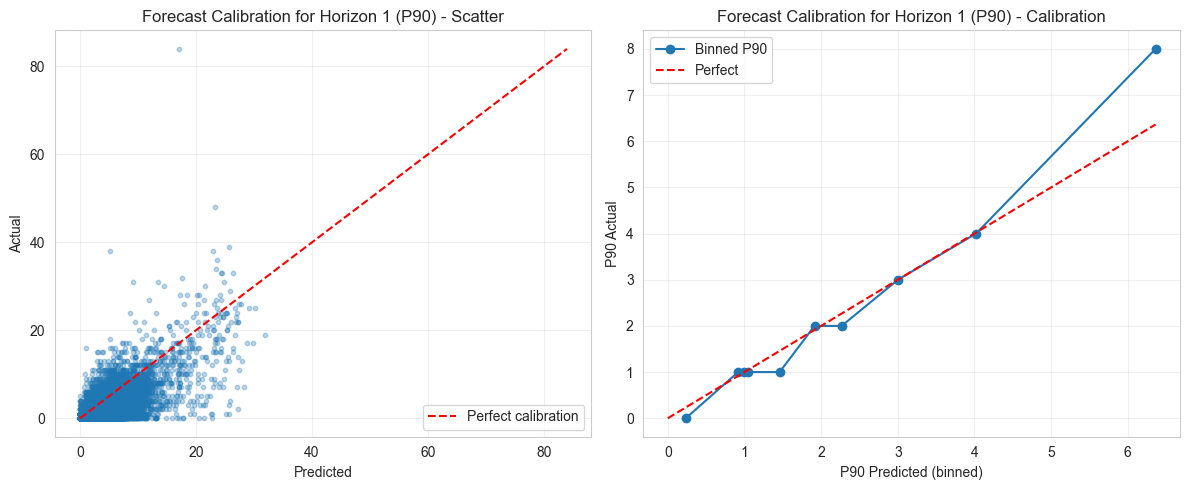

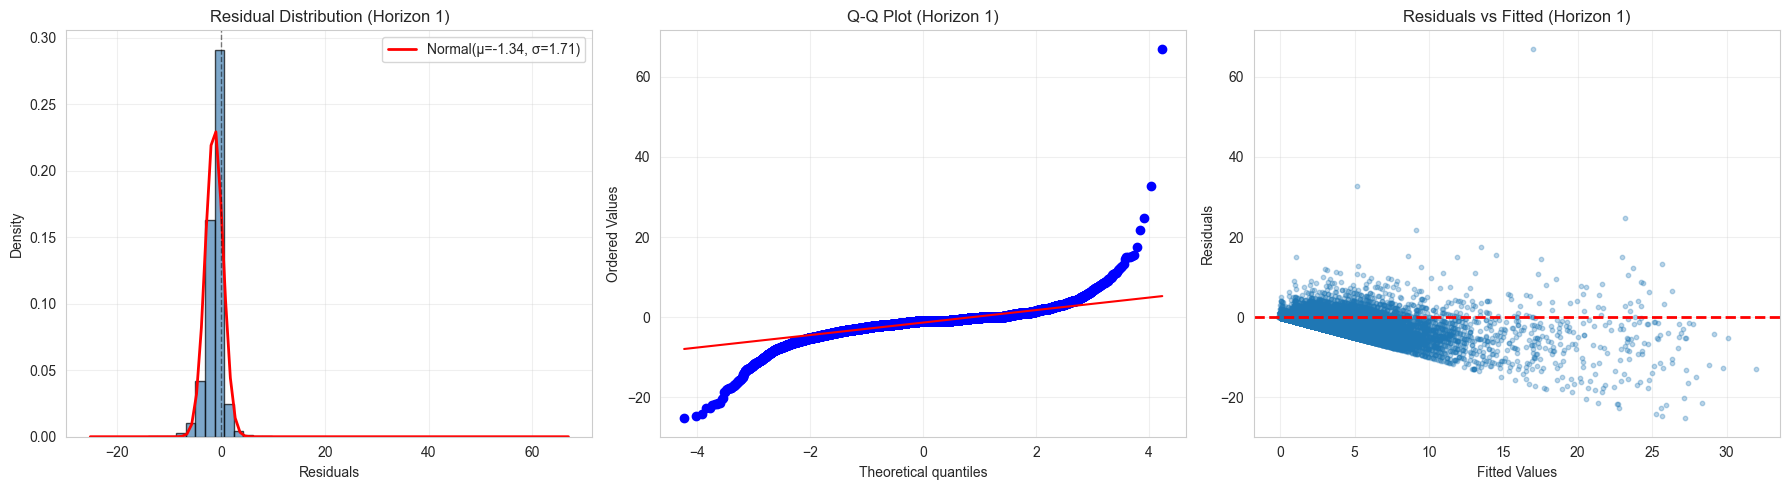


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: -1.3439
  Std Dev: 1.7092
  Median: -1.0228
  Skewness: 0.0389
  Kurtosis: 60.7137

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.8275
  P-value: 7.9980e-59
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 1950.2705
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.8904235371418934, 'mae': 1.439266293778425, 'poisson_deviance': 2.1476499278997414, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 2.1742794582275606, 'mae': 1.5706069063616832, 'poisson_deviance': 2.314201367486286, 'n_samples': 60374}}



In [15]:
reload(forecast)
forecast.evaluate_models(bundle_90, model_type = '90')

### Evaluate 50th Percentile Models

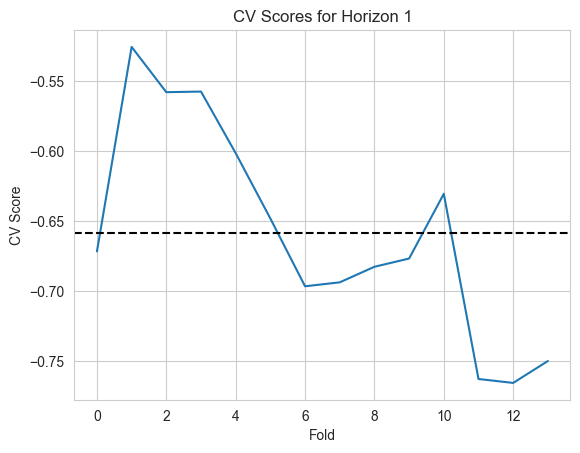

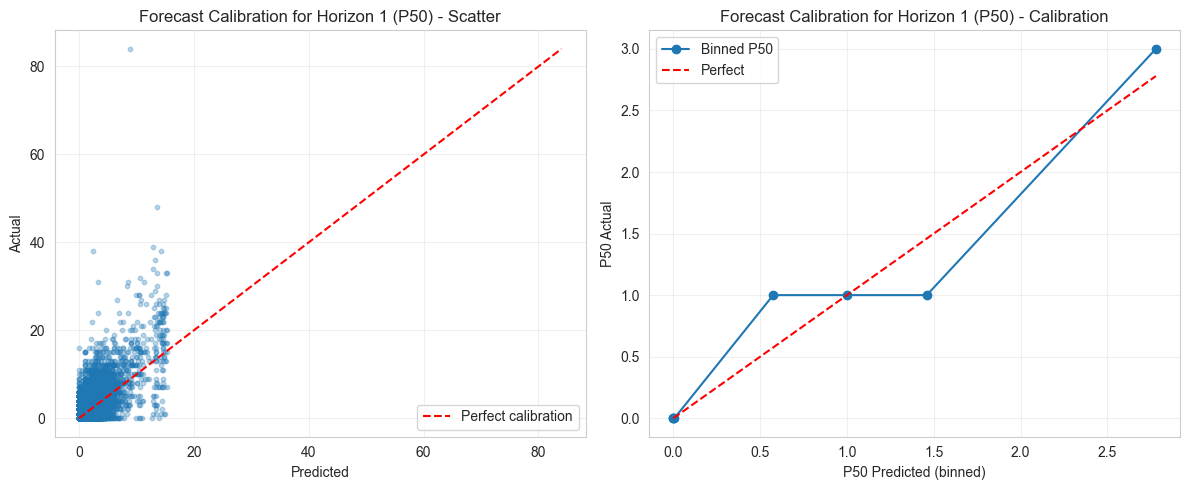

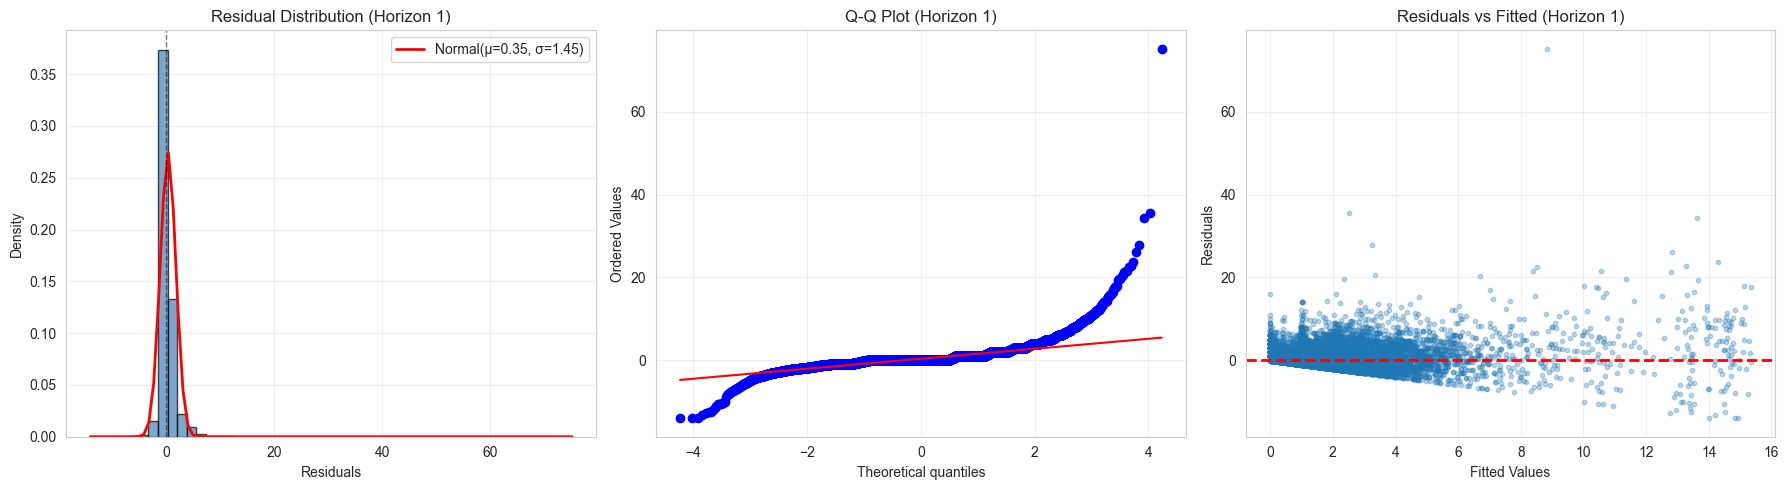


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.3532
  Std Dev: 1.4536
  Median: 0.0000
  Skewness: 5.3051
  Kurtosis: 152.4714

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.6783
  P-value: 6.6559e-71
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 5174.7387
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.2563025309304954, 'mae': 0.650017359121064, 'poisson_deviance': 6.053613673217477, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 1.4958509056695146, 'mae': 0.7346907455709496, 'poisson_deviance': 6.192973323253675, 'n_samples': 60374}}



In [16]:
reload(forecast)
forecast.evaluate_models(bundle_50, model_type = '50')

### Evaluate 10th Percentile Models

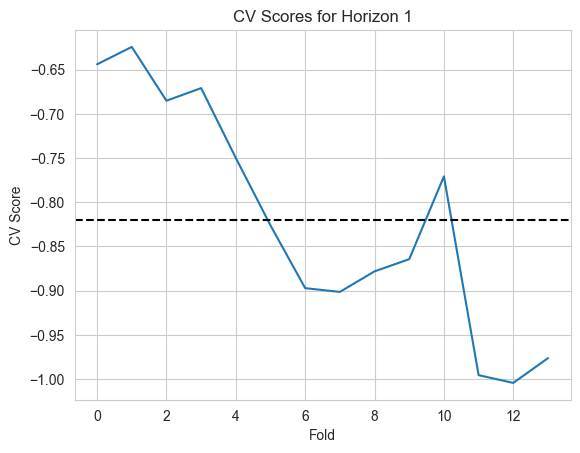

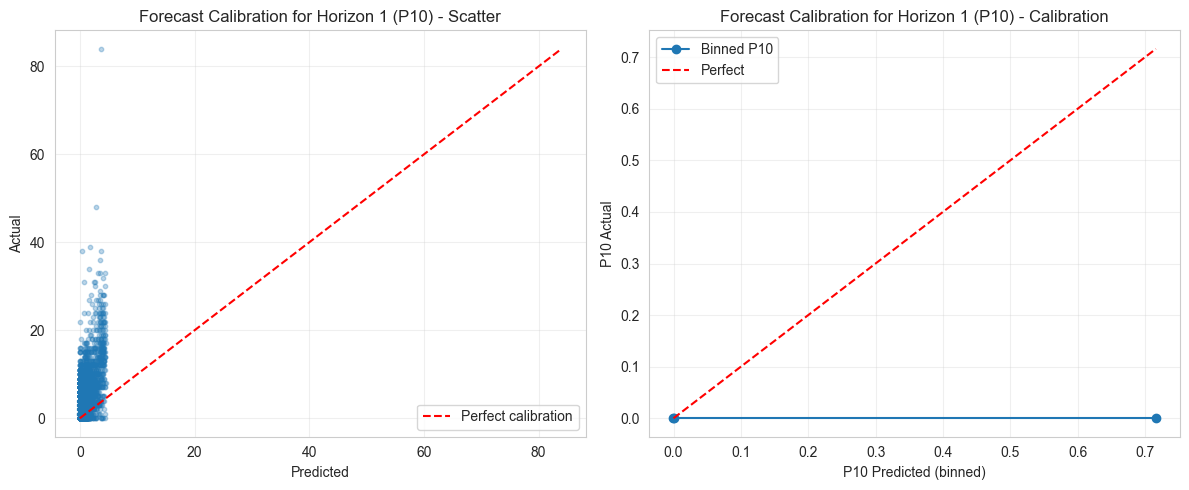

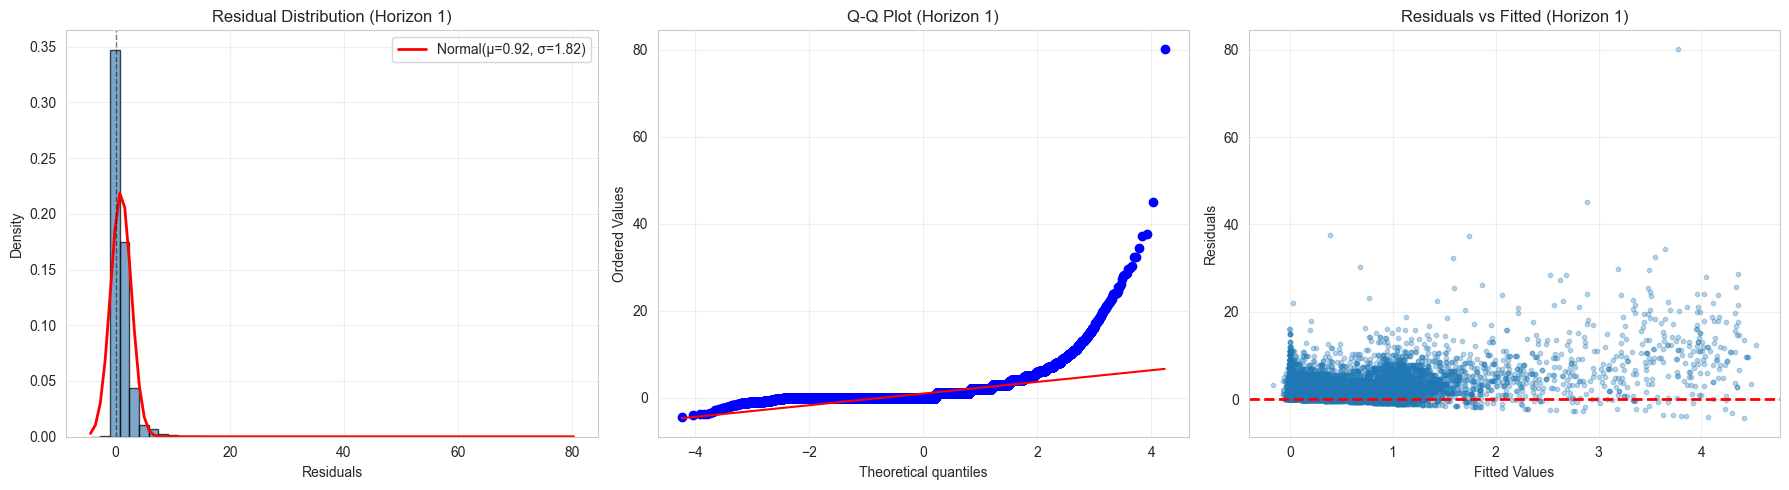


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.9190
  Std Dev: 1.8158
  Median: 0.0000
  Skewness: 6.1184
  Kurtosis: 106.8493

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.5286
  P-value: 6.9963e-79
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 7663.6605
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.6884445410347833, 'mae': 0.8294098778807758, 'poisson_deviance': 24.31512702379893, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 2.0350784649815044, 'mae': 0.9316220445516109, 'poisson_deviance': 25.09913265897668, 'n_samples': 60374}}



In [17]:
reload(forecast)
forecast.evaluate_models(bundle_10, model_type = '10')